## Breast Cancer Decision Tree

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

## Source

Wisconsin Breast Cancer Database (January 8, 1991)

1. O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear 
      programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.
2. William H. Wolberg and O.L. Mangasarian: "Multisurface method of 
  pattern separation for medical diagnosis applied to breast cytology", 
  Proceedings of the National Academy of Sciences, U.S.A., Volume 87, 
  December 1990, pp 9193-9196.
3. O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition 
  via linear programming: Theory and application to medical diagnosis", 
  in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying
  Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30.
4. K. P. Bennett & O. L. Mangasarian: "Robust linear programming 
  discrimination of two linearly inseparable sets", Optimization Methods
  and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).

[https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/)



###  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)

In [3]:
# import the data

columns = ['id', 'thickness', 'uniform_size', 'uniform_shape', 'marginal_adhesion', 'SEC_size', 
           'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']


df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data", names=columns)

df.head()

,id,thickness,uniform_size,uniform_shape,marginal_adhesion,SEC_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
id                   699 non-null int64
thickness            699 non-null int64
uniform_size         699 non-null int64
uniform_shape        699 non-null int64
marginal_adhesion    699 non-null int64
SEC_size             699 non-null int64
bare_nuclei          699 non-null object
bland_chromatin      699 non-null int64
normal_nucleoli      699 non-null int64
mitoses              699 non-null int64
class                699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [5]:
df.count()

id                   699
thickness            699
uniform_size         699
uniform_shape        699
marginal_adhesion    699
SEC_size             699
bare_nuclei          699
bland_chromatin      699
normal_nucleoli      699
mitoses              699
class                699
dtype: int64

## Preprocessing

In [6]:
# clone df so that you don't have to rerun getting the data each time
df_preprocessing = df.copy(deep=True)

# remove the id column
df_preprocessing.drop('id', axis=1, inplace=True)

# convert to 0 = beningn, and 1 = malignant 
df_preprocessing['class'] = df_preprocessing['class'].apply(lambda x : 0 if x == 2 else 1)

# get rid of rows which are all null
df_preprocessing.dropna(how='all', inplace=True, axis=0)

# finding misc values
for col in df_preprocessing.columns:
    print(df_preprocessing[col].unique())

[ 5  3  6  4  8  1  2  7 10  9]
[ 1  4  8 10  2  3  7  5  6  9]
[ 1  4  8 10  2  3  5  6  7  9]
[ 1  5  3  8 10  4  6  2  9  7]
[ 2  7  3  1  6  4  5  8 10  9]
['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']
[ 3  9  1  2  4  5  7  8  6 10]
[ 1  2  7  4  5  3 10  6  9  8]
[ 1  5  4  2  3  7 10  8  6]
[0 1]


In [7]:
# find the column which contains string values and '?'
df_preprocessing.columns[5]

'bare_nuclei'

In [8]:
# convert the missing bare_nuclei to the mean value
df_preprocessing = df_preprocessing.apply(pd.to_numeric, errors='coerce')
mean_bare_nuclei = round(df_preprocessing['bare_nuclei'].mean())
df_preprocessing['bare_nuclei'].fillna(value=mean_bare_nuclei, inplace=True)
df_preprocessing = df_preprocessing.apply(pd.to_numeric, errors='coerce', downcast='integer')

# update db
df = df_preprocessing

## Descriptive statistics

In [9]:
df.describe()

,thickness,uniform_size,uniform_shape,marginal_adhesion,SEC_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.555079,3.437768,2.866953,1.589413,0.344778
std,2.815741,3.051459,2.971913,2.855379,2.214300,3.602496,2.438364,3.053634,1.715078,0.475636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70dcb5d240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f70dc0f3588>]], dtype=object)

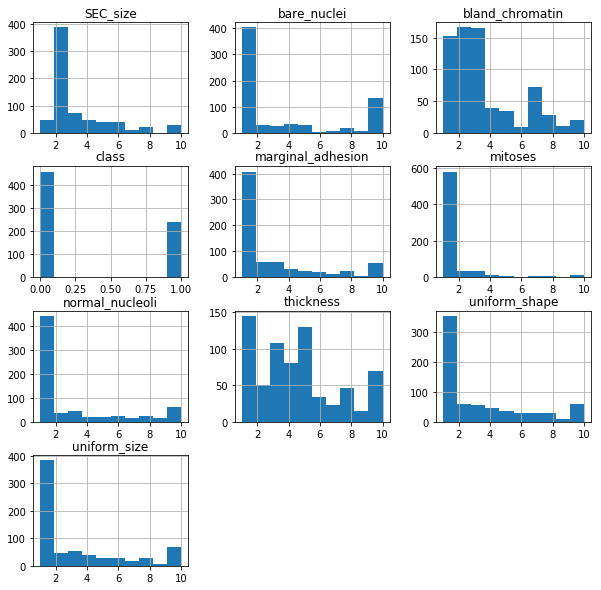

In [10]:
df.hist(figsize=(10,10))


thickness                AxesSubplot(0.125,0.71587;0.227941x0.16413)
uniform_size          AxesSubplot(0.398529,0.71587;0.227941x0.16413)
uniform_shape         AxesSubplot(0.672059,0.71587;0.227941x0.16413)
marginal_adhesion       AxesSubplot(0.125,0.518913;0.227941x0.16413)
SEC_size             AxesSubplot(0.398529,0.518913;0.227941x0.16413)
bare_nuclei          AxesSubplot(0.672059,0.518913;0.227941x0.16413)
bland_chromatin         AxesSubplot(0.125,0.321957;0.227941x0.16413)
normal_nucleoli      AxesSubplot(0.398529,0.321957;0.227941x0.16413)
mitoses              AxesSubplot(0.672059,0.321957;0.227941x0.16413)
class                      AxesSubplot(0.125,0.125;0.227941x0.16413)
dtype: object

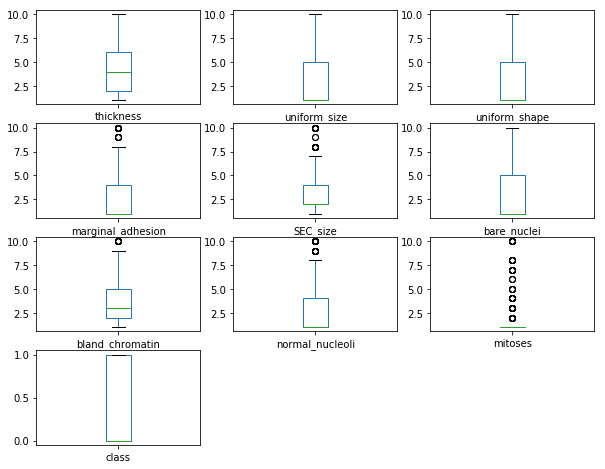

In [11]:
df.plot(kind= 'box' , subplots=True, layout=(4,3), sharex=False, figsize=(10,8))

Text(0.5,1,'Correlation Matrix of Breast Cancer dataset')

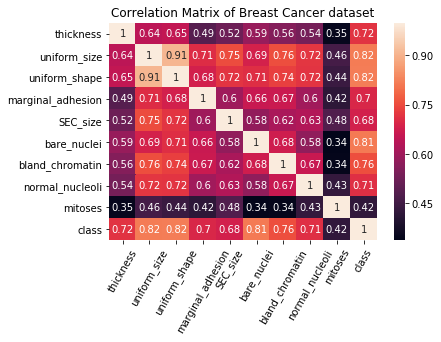

In [12]:
corr = df.corr()
ax = sns.heatmap(corr, annot = True)
plt.setp(ax.axes.get_xticklabels(), rotation=60)
plt.title('Correlation Matrix of Breast Cancer dataset')

The greatest correlations are uniform size, uniform shape and bland_chromatin

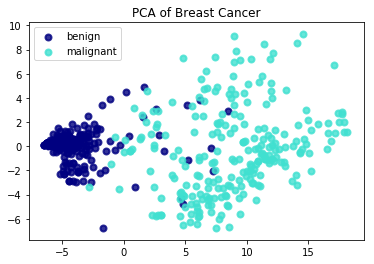

In [13]:
# based on: http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html
df_train = df.copy(deep=True)
y = df_train['class']
df_train.drop('class', axis=1, inplace=True)
X = df_train

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure()
colors = ['navy', 'turquoise']
lw = 2

for color, i, target_name in zip(colors, [0, 1], ['benign','malignant']):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.title('PCA of Breast Cancer')
plt.legend(loc='best', shadow=False, scatterpoints=1)

Visualisation of the separation of benign and malignant

## Training with Hyperparamter tuning

In [14]:
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import  GridSearchCV

In [15]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.2, random_state=33)

print("training size", len(X_train))
print("test size", len(X_test))

clf_dt = DecisionTreeClassifier(criterion='entropy', random_state=40, min_samples_leaf=2)
clf_dt.fit(X_train, y_train)

params = {"max_depth": np.arange(1,20)}
grid = GridSearchCV(clf_dt, params)
grid.fit(X_train, y_train)

print("best paramaters:",grid.best_params_)

training size 559
test size 140
best paramaters: {'max_depth': 7}


## Visualisation

In [16]:
!pip install pydotplus

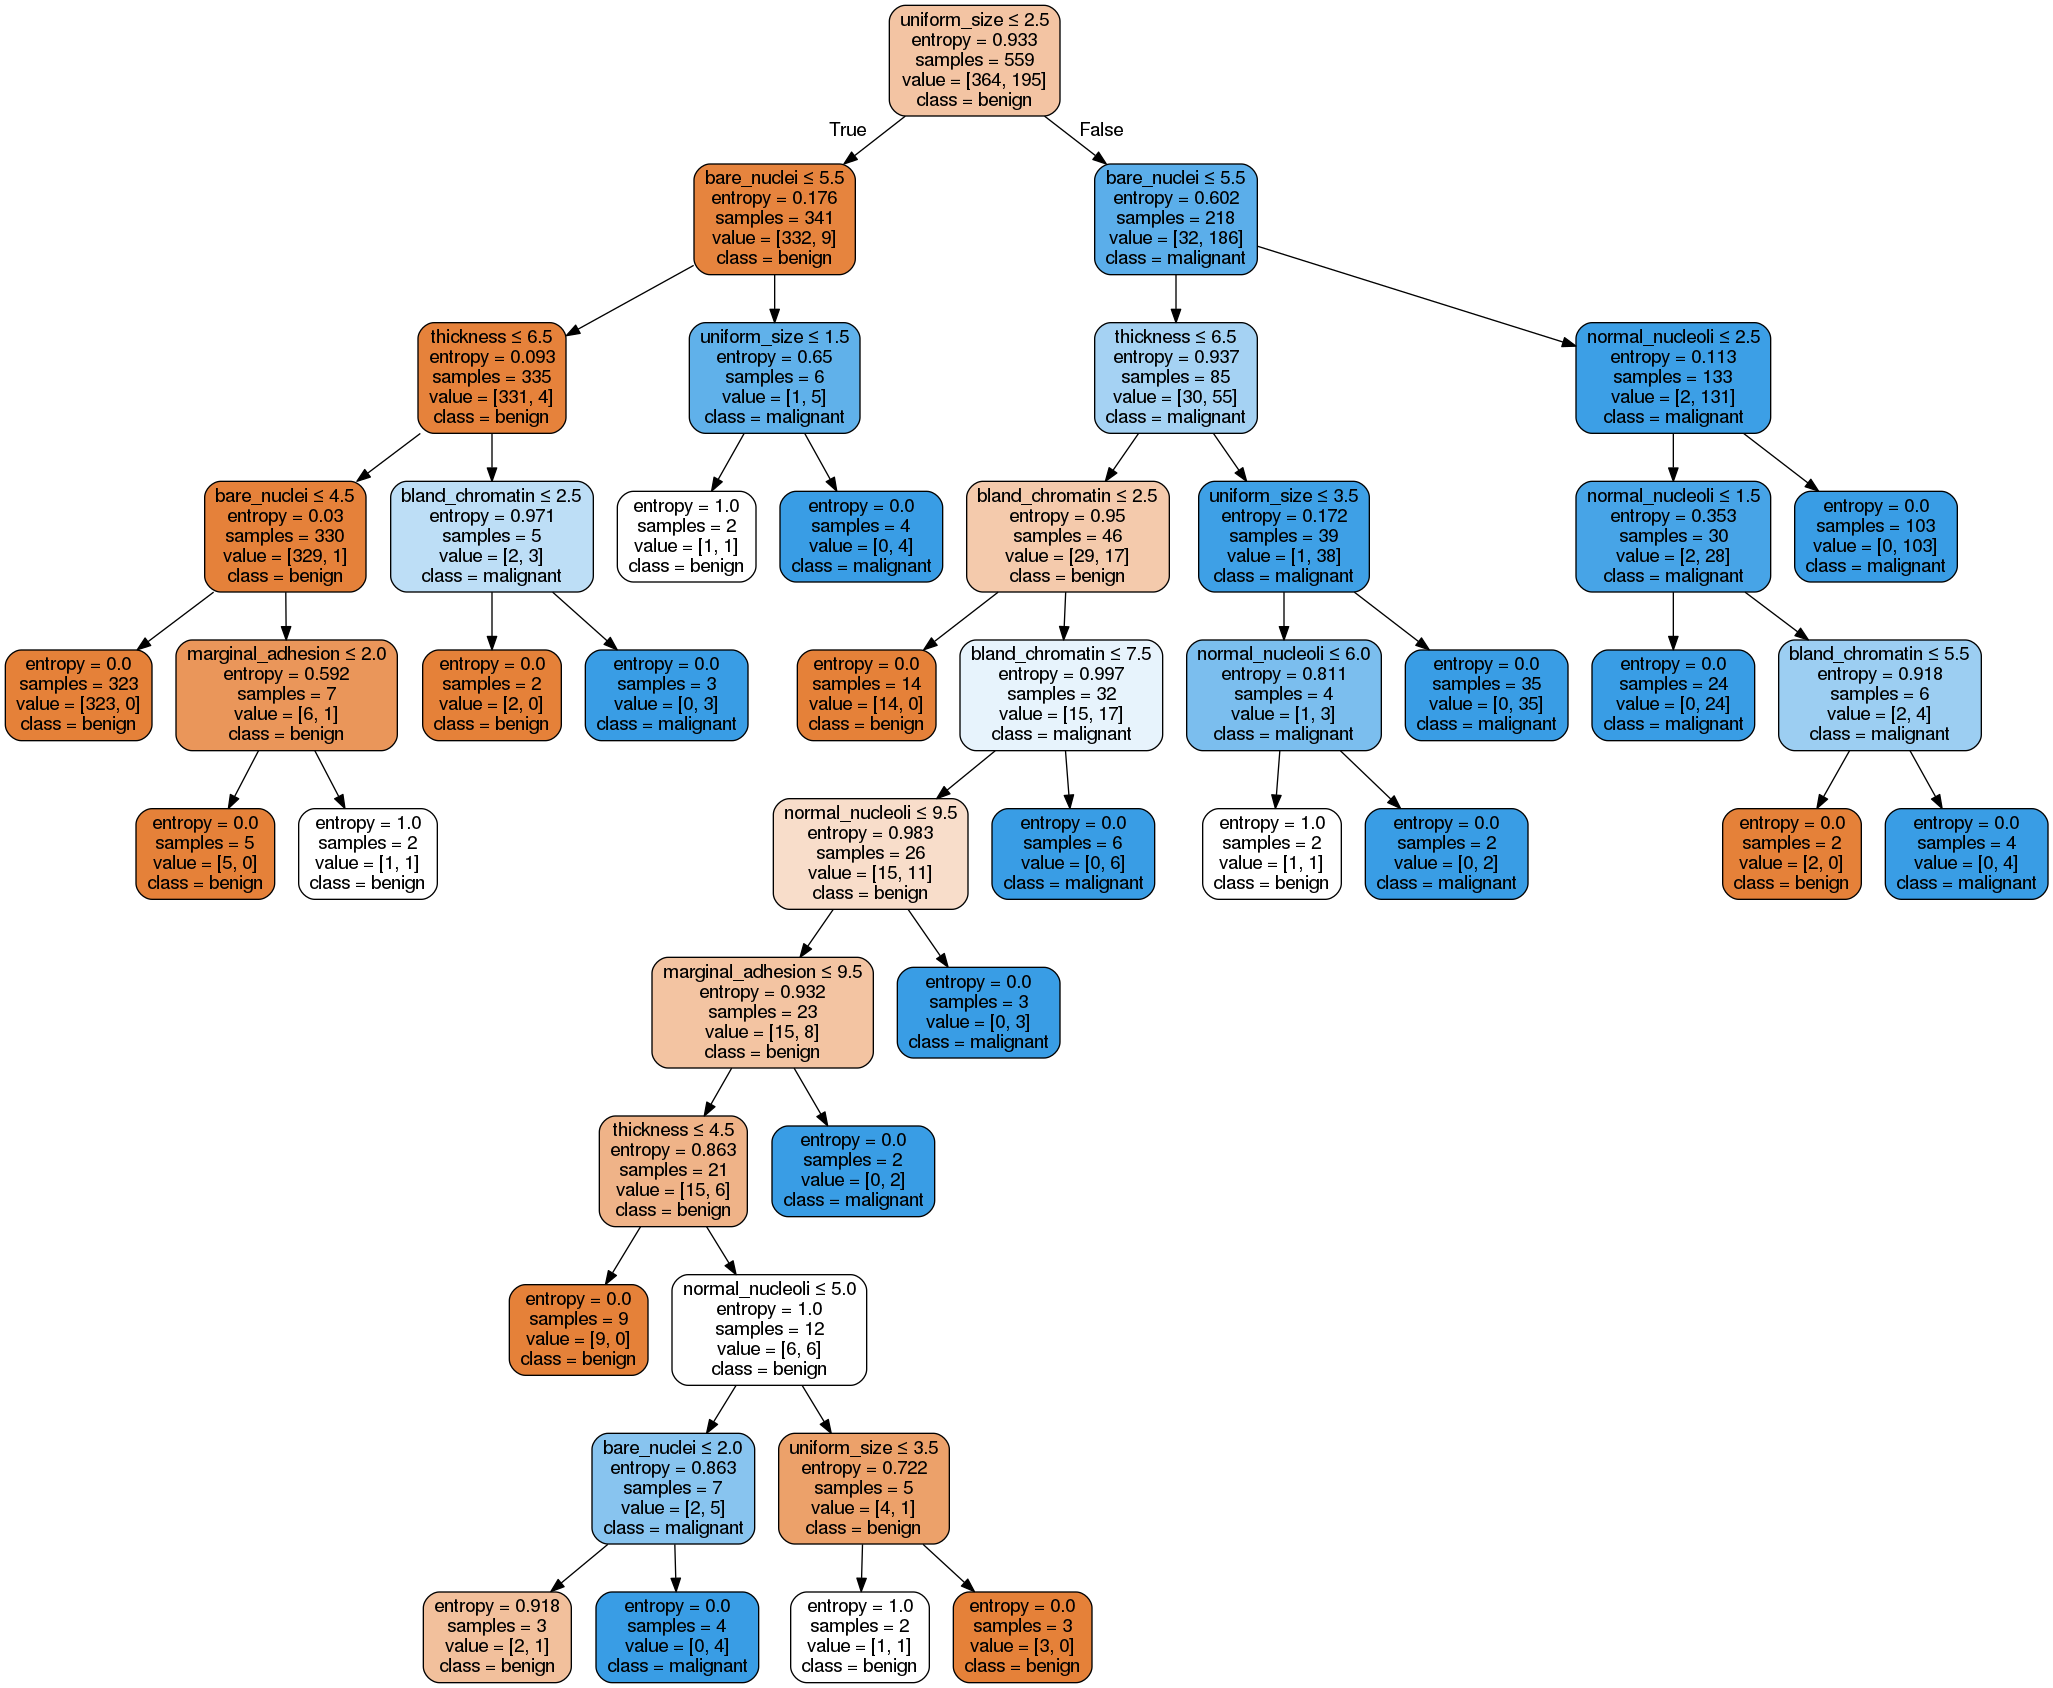

In [17]:
from sklearn import tree
from IPython.display import Image
import pydotplus

# tutorial: https://nickcdryan.wordpress.com/2017/01/23/decision-tree-visualization-with-pydotplus/
dot_data = tree.export_graphviz(clf_dt, out_file = None, feature_names=X.columns, class_names=['benign', 'malignant'], 
                filled=True, rounded=True, special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Testing

In [18]:
from sklearn import metrics 

dt_predict_train = grid.predict(X_train)
dt_predict_test = grid.predict(X_test)

print("Accuracy of training: {0:.4f}".format(metrics.accuracy_score(y_train, dt_predict_train)))
print("Accuracy of test: {0:.4f}".format(metrics.accuracy_score(y_test, dt_predict_test)))

Accuracy of training: 0.9839
Accuracy of test: 0.9357


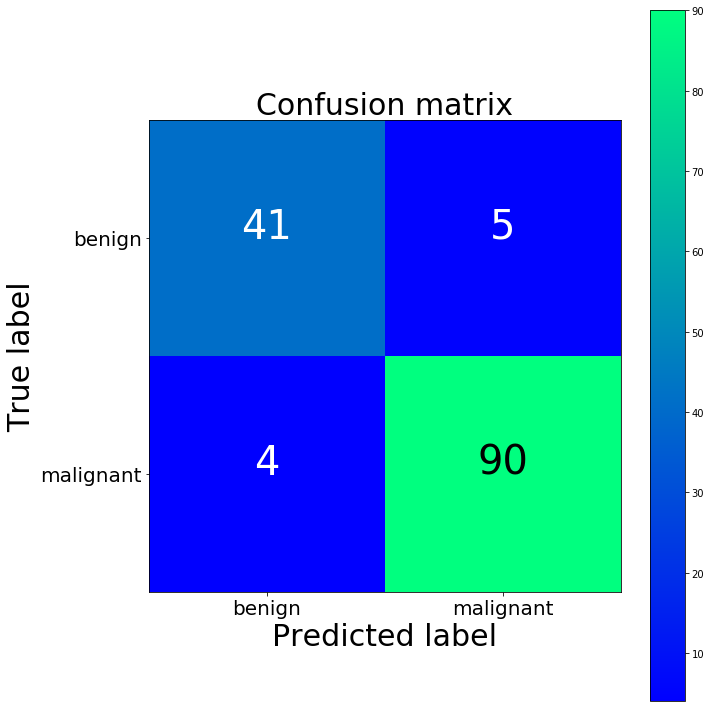

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

# helper function from: https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = metrics.confusion_matrix(y_test, dt_predict_test, labels=[1, 0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['benign','malignant'], normalize=False, title='Confusion matrix')
plt.show()